In [628]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

sns.set_style('whitegrid')

%matplotlib inline

---
## Restructuring the Data

In [629]:
data = open('./amazon-meta.txt',encoding='utf8').read().split('\n')

In [630]:
# different data points seem to be split in this flat list by an empty element: ''

data[0:21]

['# Full information about Amazon Share the Love products',
 'Total items: 548552',
 '',
 'Id:   0',
 'ASIN: 0771044445',
 '  discontinued product',
 '',
 'Id:   1',
 'ASIN: 0827229534',
 '  title: Patterns of Preaching: A Sermon Sampler',
 '  group: Book',
 '  salesrank: 396585',
 '  similar: 5  0804215715  156101074X  0687023955  0687074231  082721619X',
 '  categories: 2',
 '   |Books[283155]|Subjects[1000]|Religion & Spirituality[22]|Christianity[12290]|Clergy[12360]|Preaching[12368]',
 '   |Books[283155]|Subjects[1000]|Religion & Spirituality[22]|Christianity[12290]|Clergy[12360]|Sermons[12370]',
 '  reviews: total: 2  downloaded: 2  avg rating: 5',
 '    2000-7-28  cutomer: A2JW67OY8U6HHK  rating: 5  votes:  10  helpful:   9',
 '    2003-12-14  cutomer: A2VE83MZF98ITY  rating: 5  votes:   6  helpful:   5',
 '',
 'Id:   2']

In [631]:
dataseparated = []
datapoint = []

for val in data:
    if val == '':
        dataseparated.append(datapoint)
        datapoint = []
        continue
    datapoint.append(val)

dataseparated.remove(['# Full information about Amazon Share the Love products','Total items: 548552'])

In [632]:
# can't parallelize the list to a Spark RDD..java heap error (memory limit of driver?)

In [633]:
# each data point has a different number of features (different number of reviews, hierarchical categories, etc)
# so we cannot create a multidimensional numpy array without first filling NaN values in a dataframe?

dataseparated[1]

['Id:   1',
 'ASIN: 0827229534',
 '  title: Patterns of Preaching: A Sermon Sampler',
 '  group: Book',
 '  salesrank: 396585',
 '  similar: 5  0804215715  156101074X  0687023955  0687074231  082721619X',
 '  categories: 2',
 '   |Books[283155]|Subjects[1000]|Religion & Spirituality[22]|Christianity[12290]|Clergy[12360]|Preaching[12368]',
 '   |Books[283155]|Subjects[1000]|Religion & Spirituality[22]|Christianity[12290]|Clergy[12360]|Sermons[12370]',
 '  reviews: total: 2  downloaded: 2  avg rating: 5',
 '    2000-7-28  cutomer: A2JW67OY8U6HHK  rating: 5  votes:  10  helpful:   9',
 '    2003-12-14  cutomer: A2VE83MZF98ITY  rating: 5  votes:   6  helpful:   5']

In [634]:
# directly calling pd.DataFrame() will mix up the columns; also very computationally expensive. need to do this manually

df = pd.DataFrame()

In [635]:
def f(x):
    if x == '  discontinued product':
        return 'discontinued product'
    else:
        return x[9:]

def g(x):
    if x is np.NaN:
        return np.NaN
    else:
        return x[9:]

def h(x):
    if x is np.NaN:
        return np.NaN
    else:
        return float(x[13:])

In [636]:
# could simply do df.ID = range(len(ID)) since there are no anomalies in the ID, but this approach is better design/practice

ID = []
ASIN = []
TITLE = []
GROUP = []
SALESRANK = []
SIMILAR = []

for dp in dataseparated[:-1]:
    ID.append(dp[0])
    ASIN.append(dp[1])
    TITLE.append(dp[2])
    if len(dp) <=3 :
        GROUP.append(np.NaN)
        continue
    GROUP.append(dp[3])
    
for dp in dataseparated[:-1]:
    if len(dp) <= 4 :
        SALESRANK.append(np.NaN)
        continue
    SALESRANK.append(dp[4])
    
for dp in dataseparated[:-1]:
    if len(dp)<=5:
        SIMILAR.append(np.NaN)
        continue
    SIMILAR.append(int(dp[5][11:].split()[0]))
    
df['ID'] = ID
df.ID = df.ID.apply(lambda x: x[6:]).astype(int)
df['ASIN'] = ASIN
df.ASIN = df.ASIN.apply(lambda x: x[6:])
df['TITLE'] = TITLE
df.TITLE = df.TITLE.apply(f)
df['GROUP'] = GROUP
df.GROUP = df.GROUP.apply(g)
df['SALESRANK'] = SALESRANK
df.SALESRANK = df.SALESRANK.apply(h)
df['SIMILAR'] = SIMILAR

In [637]:
df.SIMILAR.max()

5.0

In [638]:
# max number of similar ASINs is 5. create a column for each, with NaN values for those w/ less than 5 similar products
# can't use a single for loop because of the continue statements

SIM1 = []
SIM2 = []
SIM3 = []
SIM4 = []
SIM5 = []

for dp in dataseparated[:-1]:
    if (len(dp)<=5) or (int(dp[5][11:].split()[0])<1):
        SIM1.append(np.NaN)
        continue
    SIM1.append(dp[5][11:].split()[1])

for dp in dataseparated[:-1]:
    if (len(dp)<=5) or (int(dp[5][11:].split()[0])<2):
        SIM2.append(np.NaN)
        continue
    SIM2.append(dp[5][11:].split()[2])
    
for dp in dataseparated[:-1]:
    if (len(dp)<=5) or (int(dp[5][11:].split()[0])<3):
        SIM3.append(np.NaN)
        continue
    SIM3.append(dp[5][11:].split()[3])
    
for dp in dataseparated[:-1]:
    if (len(dp)<=5) or (int(dp[5][11:].split()[0])<4):
        SIM4.append(np.NaN)
        continue
    SIM4.append(dp[5][11:].split()[4])
    
for dp in dataseparated[:-1]:
    if (len(dp)<=5) or (int(dp[5][11:].split()[0])<5):
        SIM5.append(np.NaN)
        continue
    SIM5.append(dp[5][11:].split()[5])
    
df['SIM1'] = SIM1
df['SIM2'] = SIM2
df['SIM3'] = SIM3
df['SIM4'] = SIM4
df['SIM5'] = SIM5

In [639]:
CATEGORIES = []

for dp in dataseparated[:-1]:
    if len(dp)<=7:
        CATEGORIES.append(np.NaN)
        continue
    CATEGORIES.append(int(dp[6].split()[1]))
        
df['CATEGORIES'] = CATEGORIES

In [640]:
# list of lists containing categories for each data point. difficult to structure because of different sizes...fill with NaN
# so the internal lists are all the same size?
# we don't need to actually structure all of the category data.. just focus on answering what the questions is asking

CATS = []

for dp in dataseparated:
    if len(dp) < 7:
        CATS.append([np.NaN])
        continue
    CATS.append(dp[7:7+int(dp[6].split()[1])])

In [641]:
for dp in CATS:
    while(len(dp)<116):
        dp.append(np.NaN)
        
CATS_df = pd.DataFrame(CATS)

In [642]:
REVIEWS = []

for dp in dataseparated[:-1]:
    if len(dp) < 7:
        REVIEWS.append(np.NaN)
        continue
    REVIEWS.append(int(dp[7+int(dp[6].split()[1])].split()[2]))
    
df['REVIEWS_COUNT'] = REVIEWS

In [643]:
RATING = []

for dp in dataseparated[:-1]:
    if len(dp) < 7:
        RATING.append(np.NaN)
        continue
    RATING.append(float(dp[7+int(dp[6].split()[1])].split()[7]))
    
df['AVG_RATING'] = RATING

In [644]:
# similar to CATS..may or may not further structure the data

REVIEWS1 = []

for dp in dataseparated:
    if len(dp) < 7:
        REVIEWS1.append([np.NaN])
        continue
    REVIEWS1.append(dp[8+int(dp[6].split()[1]):\
                 8+int(dp[6].split()[1])+int(dp[7+int(dp[6].split()[1])].split()[2])])

In [645]:
df.head()

,ID,ASIN,TITLE,GROUP,SALESRANK,SIMILAR,SIM1,SIM2,SIM3,SIM4,SIM5,CATEGORIES,REVIEWS_COUNT,AVG_RATING
0,0,0771044445,discontinued product,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,1,0827229534,Patterns of Preaching: A Sermon Sampler,Book,396585.0,5.0,0804215715,156101074X,0687023955,0687074231,082721619X,2.0,2.0,5.0
2,2,0738700797,Candlemas: Feast of Flames,Book,168596.0,5.0,0738700827,1567184960,1567182836,0738700525,0738700940,2.0,12.0,4.5
3,3,0486287785,World War II Allied Fighter Planes Trading Cards,Book,1270652.0,0.0,NaN,NaN,NaN,NaN,NaN,1.0,1.0,5.0
4,4,0842328327,Life Application Bible Commentary: 1 and 2 Tim...,Book,631289.0,5.0,0842328130,0830818138,0842330313,0842328610,0842328572,5.0,1.0,4.0


---
## Exploratory Analysis

__1. Trustworthiness of ratings__

Ratings are susceptible to manipulation, bias etc. What can you say (quantitatively
speaking) about the ratings in this dataset?

In [646]:
# on average, there are about 14 reviews per item. this is enough that, on average, it is unlikely that items' reviews are 
# susceptible to bias/manipulation by single parties. however, there is quite a bit of variance in the review count,
# so it seems that this depends a bit more on the specific item in question

df.REVIEWS_COUNT.describe()

count    542684.000000
mean         14.339818
std          74.768369
min           0.000000
25%           0.000000
50%           2.000000
75%           8.000000
max        5545.000000
Name: REVIEWS_COUNT, dtype: float64

In [647]:
reviews_count_means = []

for rating in np.sort(df.AVG_RATING.unique()):
    if np.isnan(rating):
        continue
    reviews_count_means.append(df[df.AVG_RATING==rating].REVIEWS_COUNT.mean())

Text(0.5,0,'Rating')

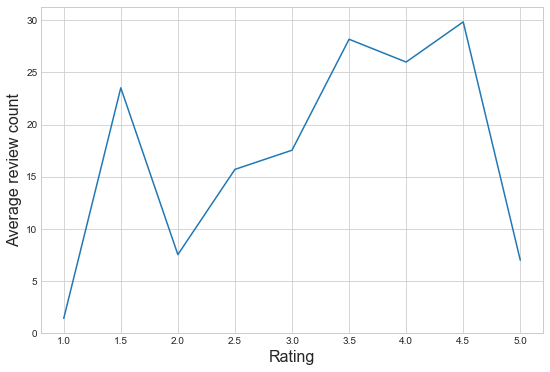

In [648]:
# leave out NaN rating and 0 reviews

# the distribution looks somewhat bimodal--i.e. items with extreme ratings (1 or 5) have not had very many reviews..these are 
# more susceptible to bias/manipulation. there are not enough reviews for the ratings to be statistically reliable

# there are two general "peaks" -- a low rating peak at 1.5 and a high rating peak at around 4. These ratings are more 
# robust as their review counts tend to be higher. (I assume that people tend not to rate items at these "in-between"
# values. it is only after many ratings that the average ends up being around these points)

fig, ax = plt.subplots(1,1,figsize=(9,6))

ax.plot(np.sort(df.AVG_RATING.unique())[1:-1],reviews_count_means[1:])
ax.set_ylabel('Average review count',fontsize=16)
ax.set_xlabel('Rating',fontsize=16)

Text(0,0.5,'Review Count')

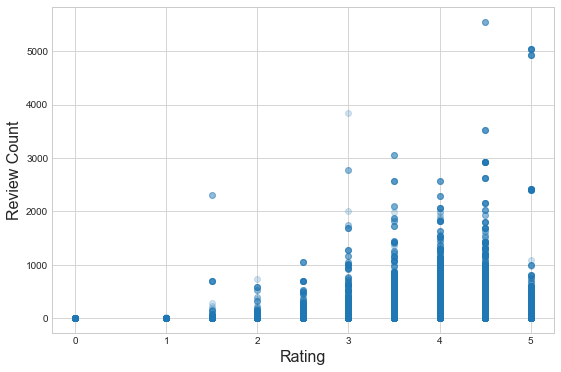

In [649]:
# this pattern seems especially true for items with very low ratings (1 or 1.5). these items have not been reviewed by
# many users, and their overall average rating is "manipulated" by the small sample of reviewers to be low

# in general, we tend to be able to have more confidence in the "in-between" reviews because of their greater review counts

# there do exist, however, some outliers which have a considerable review count yet also achieve an extreme ratings.
# (these are the top/left and top/right points)

fig, ax = plt.subplots(1,1,figsize=(9,6))

ax.scatter(df.AVG_RATING,df.REVIEWS_COUNT,alpha=0.2)
ax.set_xlabel('Rating',fontsize=16)
ax.set_ylabel('Review Count',fontsize=16)

In [704]:
# depending on the group a product belongs to, it may have a greater or lesser tendency to be thoroughly reviewed.
# due to this, different groups probably have more reliable average ratings. (e.g. a DVD product rating will probably be 
# more reliable than a Software product rating)



df.groupby('GROUP').mean()[['REVIEWS_COUNT','AVG_RATING']]

,REVIEWS_COUNT,AVG_RATING
GROUP,,
Baby Product,3.000000,4.500000
Book,11.961508,3.051148
CE,1.250000,1.750000
DVD,42.077466,3.670996
Music,13.685905,3.635529
Software,2.600000,4.500000
Sports,5.000000,4.000000
Toy,4.625000,3.812500
Video,31.702193,3.563105


In [709]:
# weighted average ratings by group..books and video games tend to be rated higher than sports and DVDs

ratings_by_group = []

for group in np.sort(df.GROUP.unique()[1:]):
    weighted_avg = (df[df.GROUP==group].AVG_RATING*df[df.GROUP==group].REVIEWS_COUNT).sum()\
    /df[df.GROUP==group].REVIEWS_COUNT.sum()
    
    ratings_by_group.append(weighted_avg)
    
list(zip(df.GROUP.unique()[1:],ratings_by_group))

[('Book', 4.5),
 ('Music', 4.164011659486407),
 ('DVD', 3.2),
 ('Video', 4.054802040483656),
 ('Toy', 4.3720047689922),
 ('Video Games', 4.461538461538462),
 ('Software', 4.0),
 ('Baby Product', 4.513513513513513),
 ('CE', 4.110301662220398),
 ('Sports', 2.5)]

__2. Category bloat__

Consider the product group named 'Books'. Each product in this group is associated with
categories. Naturally, with categorization, there are tradeoffs between how broad or
specific the categories must be.


__For this dataset, quantify the following:__

a. Is there redundancy in the categorization? How can it be identified/removed?

b. Is is possible to reduce the number of categories drastically (say to 10% of existing
categories) by sacrificing relatively few category entries (say close to 10%)?

In [650]:
# on average, individual books are placed into between 3 and 4 categories. there does seem to be a bit of redundancy
# there is also a notable amount of variance around this figure..many books are placed into even more redundant categories

print(df[df.GROUP=='Book'].CATEGORIES.mean())
print(df[df.GROUP=='Book'].CATEGORIES.std())

3.6597350855394715
2.427499620161403


In [651]:
# number of unique book categories.
# we want to reduce this to about 10% of its current size, i.e. reduce this number to around 1,280... (by about 11,500)

len(pd.unique(CATS_df[:-1][df.GROUP=='Book'].values.ravel()))

12854

In [652]:
# number of category entries
# ...while reducing the number of entries by only about 10%. i.e. reduce this number to around 1,300,000

CATS_df[:-1][df.GROUP=='Book'].notnull().sum().sum()

1440329

In [653]:
value_counts = BOOKS_df.stack().value_counts()

In [719]:
# there are many categories which only contain 1 entry.. these are redundant and should be removed first if we desire to 
# lower the category count as much as possible while removing as few data points as possible. 

# since value_counts is ordered, we can splice this list to remove the categories which appears on the least entries
# we take the sum of the to-be-removed value counts to see how many entries we would lose

value_counts.sort_values(ascending=True)[0:5]

   |Books[283155]|Subjects[1000]|Computers & Internet[5]|Hardware[549652]|Microprocessors & System Design[3723]|Intel[3732]    1
   |Books[283155]|Subjects[1000]|Horror[49]|Authors, A-Z[5439]|( H )[6918]|Howard, Robert[7203]                                1
   |Books[283155]|Subjects[1000]|Romance[23]|Authors, A-Z[12831]|( K )[13084]|Kendrick, Sharon[466416]                         1
   |Books[283155]|Subjects[1000]|History[9]|Ancient[4873]|Series[465334]|Loeb Classics[465336]                                 1
   |Books[283155]|Subjects[1000]|Horror[49]|Authors, A-Z[5439]|( J )[7280]|James, Henry[7314]                                  1
dtype: int64

In [716]:
# to achieve only 10% reduction in entries, we need to keep about 26% of original categories

# note - we can re-arrange all this so we instead input the desired reduction/preservation and output the 
# % threshold..this is slightly lazy/sloppy design

cat_count_threshold = int(len(value_counts)*.26)

print(value_counts[cat_count_threshold:].sum()/CATS_df[:-1][df.GROUP=='Book'].notnull().sum().sum())
print(cat_count_threshold/len(pd.unique(CATS_df[:-1][df.GROUP=='Book'].values.ravel())))

0.1032722384955104
0.25991909133343705


In [718]:
# we need to remove about 28% of entries, in order to reduce categories to 10% of original categories

cat_count_threshold = int(len(value_counts)*.10)

print(value_counts[cat_count_threshold:].sum()/CATS_df[:-1][df.GROUP=='Book'].notnull().sum().sum())
print(cat_count_threshold/len(pd.unique(CATS_df[:-1][df.GROUP=='Book'].values.ravel())))

0.2825090656370871
0.09996888128209118


In [657]:
# the target of 10% reduction in entries for a 90% reduction in categories is not feasible, as shown by cells above

---

__1. Algorithm thinking__

How would you build the product categorization from scratch, using similar/co-purchased
information? 

In [724]:
# using the given groups, i would count the number of occurences of each unique co-purchased ASIN and compile a data table
# of those which occur most frequently. for a given ASIN that occures very frequently, i would assign it a category.
# then, i would iteratively repeat the process within the datapoints which contain that ASIN to find other 
# 'very-frequent' occurences which i would assign to a sub-cateogry. i would repeat this process to a desired extent
# such that i have groupings (defined subsets) of datapoints to a desired level of depth and breadth. depth is achieved
# through the iterative process of adding sub-categories, whereas breadth is achieved by creating new categories
# within a level by moving down the list of frequently-occuring ASINs. since this is hierarchical, we can increase 
# breadth/depth at any level...to the extent to which we have available data

__2. Product thinking__

Now, put on your 'product thinking' hat.

a. Is it a good idea to show users the categorization hierarchy for items?

b. Is it a good idea to show users similar/co-purchased items?

c. Is it a good idea to show users reviews and ratings for items?

d. For each of the above, why? How will you establish the same?

In [720]:
# a

# yes. if a user searches for a specific item and is presented with the categorization hierarchy for that item, he will
# know what grouping (product subset) to explore to find similar products. quite often, users will use the web to 
# research and find products fit to their preferences. this is often not the first search made, and showing the 
# categorization hierarchy will increase the probability that the user will find a product he will purchase

In [721]:
# b

# also yes. assuming that a user has already decided to purchase an item, showing similar and 'frequently-bought-together'
# is about as targeted as you can get with respect to advertisement. not only is the similar product relevant to the user,
# the user is currently about to purchase another product that is complimentary to the advertised item. this would be a very
# directly relevant product advertised at a very appropriate time (from the buyer's perspective)

In [722]:
# c

# this would depend on the reviews/ratings on the item. if an item has poor ratings/reviews, it is not a great idea to show the 
# customer the ratings/reviews, lest the information dissuades the customer from purchasing the item. on the other hand,
# if any item has great ratings/reviews, it would seem to be a very good idea to show the customer the ratings/reviews. the
# information will likely improve the likelihood that the customer will purchase the item.

# however, there is a question of ethics with the above answer.. it may not be ethical to show the customer inconsistent
# information, with the objective of maximizing sales. transparency and trust are important in business relations

In [723]:
# d

# answered above